# 最精简回测
大于20日均线买入，跌破20日均线卖出，不考虑手续费和滑点

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import talib as ta
import statsmodels.api as sm
%matplotlib inline

In [2]:
# 设置图表默认大小
plt.rcParams['figure.figsize'] = 10,5

In [38]:
# 设置股票和起止时间，均线周期
code = '000300.XSHG'
start_date = '2020-01-01'
end_date = '2020-12-31'
ma_period = 20

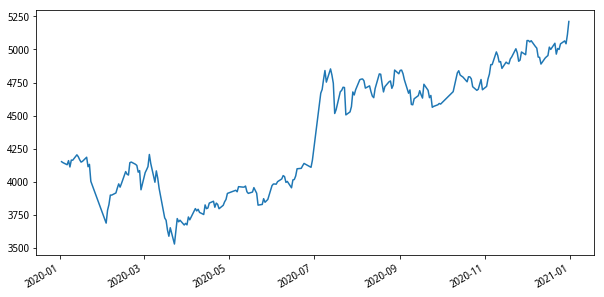

In [39]:
# 获取收盘价和成交量日线图
df = get_price(code, 
               start_date=start_date, 
               end_date=end_date, 
               frequency='daily', 
               fields=['open','close', 'volume'],
               skip_paused=False, 
               fq='pre'
              )
df['close'].plot()

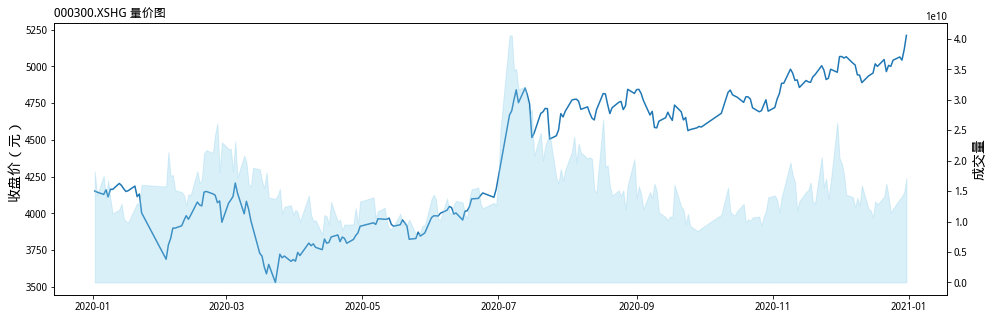

In [40]:
# 调整图表格式，同时显示成交量和收盘价，成交量使用右坐标轴，并用淡蓝色面积图表示
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(111)
ax1.plot(df['close'], label='left')
ax1.set_ylabel('收盘价（元）', fontsize=14)

ax2 = ax1.twinx()
ax2.fill_between(df.index, df['volume'], color="skyblue", alpha=0.3)
ax2.set_ylabel('成交量', fontsize=14)

plt.title("%s 量价图" % code, loc="left")
plt.show()

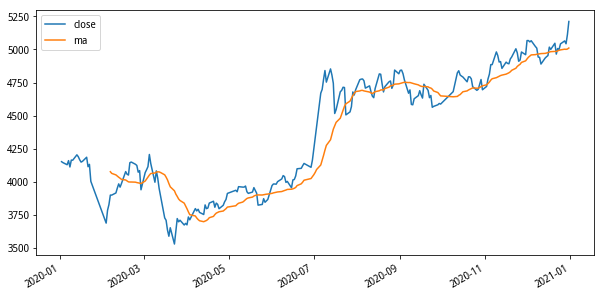

In [41]:
# 获取日均线，并查看
df['ma'] = df['close'].rolling(ma_period).mean()
df[['close','ma']].plot()

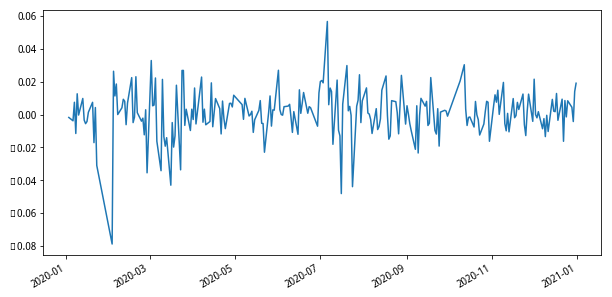

In [42]:
# 计算日波动率
df['change'] = (df['close']-df['close'].shift(1))/df['close'].shift(1)
df['change'].plot()

In [44]:
# 设置交易策略
def strategy(init_value):
    state = {'last_value': init_value,'yesterday': None}
    def fun(today):
        yesterday, last_value = state['yesterday'], state['last_value']
        new_value = last_value
        if yesterday is not None and yesterday['ma'] and today['open'] > yesterday['ma']:
            new_value = last_value + last_value * today['change']            
        
        state['last_value'] = new_value
        state['yesterday'] = today        
        return new_value
    return fun

In [45]:
# 应用策略
df['value'] = df.apply(strategy(5000), axis=1)

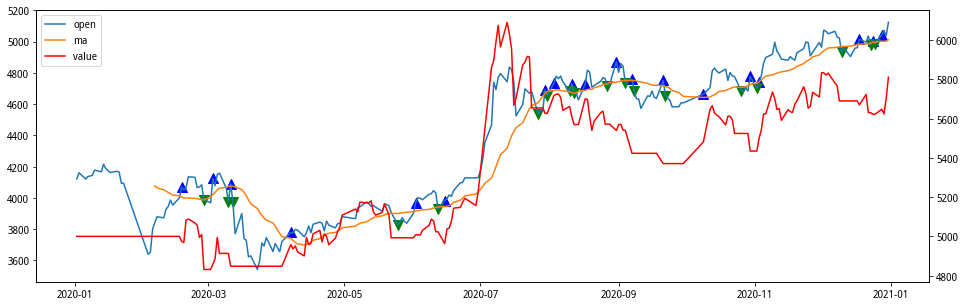

In [49]:
# 将收盘价，均线，市值画在同一张图上，市值使用右坐标轴
fig = plt.figure(figsize=(16, 5))

ax1 = fig.add_subplot(111)
ax1.plot(df['open'], label='left')
ax1.plot(df['ma'], label='left')

ax2 = ax1.twinx()
ax2.plot(df['value'], color='red')

ax2.legend([ax1.get_lines()[0], ax1.get_lines()[1], ax2.get_lines()[0]], 
           ['open', 'ma', 'value'], loc='upper left')

buys = df[(df['open'] > df['ma'].shift(1)) & (df['open'].shift(1) <= df['ma'].shift(2))]
for idx, row in buys.iterrows():
    ax1.scatter(idx, row['open'], color='blue', marker='^', s=100)
    
sells = df[(df['open'] <= df['ma'].shift(1)) & (df['open'].shift(1) > df['ma'].shift(2))]
for idx, row in sells.iterrows():
    ax1.scatter(idx, row['open'], color='green', marker='v', s=100)    

plt.show()

In [11]:
print("证券代码=%s, 开始日期=%s, 结束日期=%s" % (code, start_date, end_date))
ret = (df.iloc[-1]['value']-df.iloc[0]['value'])/df.iloc[0]['value']*100
print('策略收益率为：%.2f%%' % ret)
ret = (df.iloc[-1]['close']-df.iloc[0]['close'])/df.iloc[0]['value']*100
print('基准收益率为：%.2f%%' % ret)

证券代码=000300.XSHG, 开始日期=2020-01-01, 结束日期=2020-05-31
策略收益率为：-0.15%
基准收益率为：-5.70%


,open,close,volume,ma,change,value
2020-02-17,3999.65,4077.42,1.827790e+10,4014.0310,0.022491,5000.000000
2020-03-02,3968.84,4069.67,2.193136e+10,4005.9535,0.032898,4831.547891
2020-03-10,3975.23,4082.73,1.974164e+10,4073.4145,0.021415,4913.275342
2020-04-07,3779.91,3798.02,1.427780e+10,3742.0320,0.022837,4958.642870
